In [149]:
import warnings
warnings.filterwarnings(action='ignore')

In [150]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc
from haversine import haversine

In [151]:
path = (os.path.abspath("../data"))

#train = pd.read_parquet(path + '/train.parquet')
#test = pd.read_parquet(path + '/test.parquet')
train = pd.read_csv(path + '/train_clean.csv')
test = pd.read_csv(path + '/test_clean.csv')
sample = pd.read_csv(path + "/sample_submission.csv")
info = pd.read_csv(path+"/data_info.csv")
gc.collect()

6655

In [152]:
train = train.iloc[:,1:]
test = test.iloc[:,1:]
test

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,교통단속수,어린이보호구역수
0,TEST_000000,20220825,목,17,0,3,107,연삼로,0,0,...,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음,0.0,0.0
1,TEST_000001,20220809,화,12,0,2,103,일반국도12호선,0,0,...,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음,0.0,0.0
2,TEST_000002,20220805,금,2,0,1,103,일반국도16호선,0,0,...,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음,0.0,0.0
3,TEST_000003,20220818,목,23,0,3,103,일반국도11호선,0,0,...,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음,0.0,0.0
4,TEST_000004,20220810,수,17,0,3,106,번영로,0,0,...,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291236,TEST_291236,20220827,토,5,0,1,103,일반국도16호선,0,0,...,월산마을,33.472819,126.463030,없음,도근교,33.470483,126.460846,없음,0.0,0.0
291237,TEST_291237,20220819,금,20,0,2,103,일반국도11호선,0,0,...,영주교,33.305359,126.598914,없음,하례입구삼거리,33.300796,126.600332,없음,0.0,0.0
291238,TEST_291238,20220805,금,11,0,1,107,신대로,0,0,...,마리나사거리,33.493624,126.496769,있음,칠오광장사거리,33.497500,126.496946,있음,0.0,0.0
291239,TEST_291239,20220812,금,7,0,2,107,경찰로,0,0,...,국민의료보험관리공단,33.254782,126.507014,없음,의료보험조합,33.255659,126.507333,없음,0.0,0.0


In [153]:
#train = train.query('base_date>=20220701')

In [154]:
train = pd.merge(train,train.groupby(['road_name','day_of_week','base_hour']).target.mean(),how = 'left', 
                 on = ['road_name','day_of_week','base_hour']).rename(columns = {'target_x':'target','target_y':'target_group_mean'})
test = pd.merge(test,train.groupby(['road_name','day_of_week','base_hour']).target.mean(),how = 'left', on = ['road_name','day_of_week','base_hour']).rename(columns = {'target_x':'target','target_y':'target_group_mean'})

In [155]:
train

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,교통단속수,어린이보호구역수,target_group_mean
0,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,0.0,0.0,34.238636
1,TRAIN_0000011,20220724,일,2,0,1,107,중정로,0,0,...,126.569797,없음,정방수퍼,33.248633,126.567766,없음,40.0,0.0,0.0,33.750000
2,TRAIN_0000016,20220701,금,22,0,2,107,연동로,0,0,...,126.489979,없음,흘천5교,33.485975,126.486409,없음,35.0,0.0,0.0,22.375000
3,TRAIN_0000020,20220701,금,21,0,1,103,일반국도12호선,0,0,...,126.512851,있음,동산교,33.500132,126.512046,없음,21.0,0.0,0.0,36.329412
4,TRAIN_0000037,20220702,토,19,0,3,103,일반국도16호선,0,0,...,126.496451,없음,신제주초교입구오거리,33.483589,126.496368,있음,24.0,0.0,0.0,41.092050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274690,TRAIN_4701149,20220711,월,19,0,1,107,중문로,0,0,...,126.435439,없음,자운당교,33.251095,126.435138,없음,41.0,0.0,0.0,31.100000
274691,TRAIN_4701153,20220720,수,23,0,2,107,권학로,0,0,...,126.509066,없음,삼주연립101동,33.251045,126.510574,없음,28.0,0.0,0.0,26.312500
274692,TRAIN_4701164,20220708,금,9,0,3,103,일반국도11호선,0,0,...,126.545467,없음,염광아파트,33.469352,126.547314,없음,27.0,0.0,0.0,33.336364
274693,TRAIN_4701178,20220731,일,15,0,1,106,지방도1115호선,0,0,...,126.489006,없음,제4산록교,33.289861,126.487409,없음,52.0,0.0,0.0,52.916667


In [156]:
mean_df = train.groupby('road_rating')['target'].agg('mean')
display(mean_df)
train['road_rating_mean'] = train['road_rating'].map(mean_df)
test['road_rating_mean'] = test['road_rating'].map(mean_df)

road_rating
103    39.353222
106    46.561683
107    29.995480
Name: target, dtype: float64

In [157]:
mean_df = train.groupby('road_name')['target'].agg('mean')
display(mean_df)
train['road_name_mean'] = train['road_name'].map(mean_df)
test['road_name_mean'] = test['road_name'].map(mean_df)

road_name
-            46.508452
경찰로          23.925010
고평교          28.388244
관광단지1로       39.035933
관광단지2로       34.829589
관광단지로        30.215976
관덕로          29.354182
권학로          26.191363
동문로          23.915438
동부관광도로       36.328250
동홍로          28.173987
번영로          49.198453
산서로          30.420778
삼무로          25.000000
삼봉로          16.577010
삼성로          33.064611
새서귀로         26.201294
서사로          18.471616
수영장길         25.517665
시민광장로        24.901067
시청로          30.270066
신광로           7.500000
신대로          25.609738
신산로          24.002195
애조로          56.467344
어시천교         41.330416
연동로          23.894126
연북2교         36.486584
연북로          25.510870
연삼로          35.529420
외도천교         41.330416
일반국도11호선     36.286535
일반국도12호선     37.769818
일반국도16호선     42.440903
일반국도95호선     76.934783
일반국도99호선     40.693154
일주동로         61.000000
임항로          20.000000
제2거로교        36.970290
중문로          34.363917
중산간서로        56.958333
중앙로          26.952782
중정로          25.114271
지

In [158]:
#def distance_cal(x):
#    A = (x[0],x[1])
#    B = (x[2],x[3])
#    distance = haversine(A, B, unit = 'km')
#    return distance

In [159]:
#train['거리'] = train[['start_latitude','start_longitude','end_latitude','end_longitude']].apply(distance_cal,axis =1)
#test['거리'] = test[['start_latitude','start_longitude','end_latitude','end_longitude']].apply(distance_cal,axis =1)

In [160]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted', 'start_node_name', 'end_node_name']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [161]:
y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target','road_name','road_rating','vehicle_restricted'], axis=1)

test = test.drop(['id','base_date', 'road_name', 'road_rating','vehicle_restricted'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(test.shape)

(274695, 23)
(274695,)
(291241, 23)


In [162]:
X_train.columns

Index(['day_of_week', 'base_hour', 'road_in_use', 'lane_count', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', '교통단속수',
       '어린이보호구역수', 'target_group_mean', 'road_rating_mean', 'road_name_mean'],
      dtype='object')

In [163]:
num = ['start_latitude','start_longitude','end_latitude','end_longitude']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num] = scaler.fit_transform(X_train[num])
test[num] = scaler.transform(test[num])          #### 이거 위도나 경도 start나 end 둘 중 하나로 기준 잡고 다른하나 transform 해야될듯.

In [164]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)

In [168]:
from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor(metric= 'mae', random_state = 0,  n_estimators=10000)

In [169]:
lgbm_reg.fit(train_X, train_y, eval_set=[(val_X, val_y)], eval_metric = ['mae'],
        verbose=True, early_stopping_rounds=5)

[1]	valid_0's l1: 11.1031
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 10.343
[3]	valid_0's l1: 9.6763
[4]	valid_0's l1: 9.09586
[5]	valid_0's l1: 8.56343
[6]	valid_0's l1: 8.10259
[7]	valid_0's l1: 7.69101
[8]	valid_0's l1: 7.31342
[9]	valid_0's l1: 6.99048
[10]	valid_0's l1: 6.69445
[11]	valid_0's l1: 6.44888
[12]	valid_0's l1: 6.22236
[13]	valid_0's l1: 6.02312
[14]	valid_0's l1: 5.84448
[15]	valid_0's l1: 5.68283
[16]	valid_0's l1: 5.52594
[17]	valid_0's l1: 5.40461
[18]	valid_0's l1: 5.28617
[19]	valid_0's l1: 5.17683
[20]	valid_0's l1: 5.08226
[21]	valid_0's l1: 4.98626
[22]	valid_0's l1: 4.91777
[23]	valid_0's l1: 4.84553
[24]	valid_0's l1: 4.76933
[25]	valid_0's l1: 4.70656
[26]	valid_0's l1: 4.6458
[27]	valid_0's l1: 4.58652
[28]	valid_0's l1: 4.53897
[29]	valid_0's l1: 4.48866
[30]	valid_0's l1: 4.4379
[31]	valid_0's l1: 4.3941
[32]	valid_0's l1: 4.34937
[33]	valid_0's l1: 4.30093
[34]	valid_0's l1: 4.27128
[35]	valid_0's l1: 4.23806
[36]	vali

[330]	valid_0's l1: 3.06825
[331]	valid_0's l1: 3.06809
[332]	valid_0's l1: 3.06785
[333]	valid_0's l1: 3.06752
[334]	valid_0's l1: 3.06631
[335]	valid_0's l1: 3.0657
[336]	valid_0's l1: 3.06512
[337]	valid_0's l1: 3.06495
[338]	valid_0's l1: 3.06392
[339]	valid_0's l1: 3.06365
[340]	valid_0's l1: 3.06333
[341]	valid_0's l1: 3.06319
[342]	valid_0's l1: 3.06176
[343]	valid_0's l1: 3.06153
[344]	valid_0's l1: 3.06105
[345]	valid_0's l1: 3.06057
[346]	valid_0's l1: 3.05962
[347]	valid_0's l1: 3.05884
[348]	valid_0's l1: 3.0587
[349]	valid_0's l1: 3.05834
[350]	valid_0's l1: 3.05771
[351]	valid_0's l1: 3.05716
[352]	valid_0's l1: 3.05634
[353]	valid_0's l1: 3.05556
[354]	valid_0's l1: 3.05551
[355]	valid_0's l1: 3.05496
[356]	valid_0's l1: 3.05489
[357]	valid_0's l1: 3.05464
[358]	valid_0's l1: 3.05414
[359]	valid_0's l1: 3.05363
[360]	valid_0's l1: 3.0532
[361]	valid_0's l1: 3.05296
[362]	valid_0's l1: 3.05239
[363]	valid_0's l1: 3.05186
[364]	valid_0's l1: 3.05074
[365]	valid_0's l1: 3.0

[659]	valid_0's l1: 2.96702
[660]	valid_0's l1: 2.96682
[661]	valid_0's l1: 2.96663
[662]	valid_0's l1: 2.9666
[663]	valid_0's l1: 2.96641
[664]	valid_0's l1: 2.96633
[665]	valid_0's l1: 2.96627
[666]	valid_0's l1: 2.96607
[667]	valid_0's l1: 2.96586
[668]	valid_0's l1: 2.96573
[669]	valid_0's l1: 2.96554
[670]	valid_0's l1: 2.96545
[671]	valid_0's l1: 2.96544
[672]	valid_0's l1: 2.96505
[673]	valid_0's l1: 2.96497
[674]	valid_0's l1: 2.96483
[675]	valid_0's l1: 2.96457
[676]	valid_0's l1: 2.96429
[677]	valid_0's l1: 2.96393
[678]	valid_0's l1: 2.96368
[679]	valid_0's l1: 2.96358
[680]	valid_0's l1: 2.96331
[681]	valid_0's l1: 2.96317
[682]	valid_0's l1: 2.96311
[683]	valid_0's l1: 2.96275
[684]	valid_0's l1: 2.96273
[685]	valid_0's l1: 2.96261
[686]	valid_0's l1: 2.96254
[687]	valid_0's l1: 2.96223
[688]	valid_0's l1: 2.96204
[689]	valid_0's l1: 2.96184
[690]	valid_0's l1: 2.96158
[691]	valid_0's l1: 2.96142
[692]	valid_0's l1: 2.96127
[693]	valid_0's l1: 2.96118
[694]	valid_0's l1: 2

[987]	valid_0's l1: 2.92313
[988]	valid_0's l1: 2.92305
[989]	valid_0's l1: 2.92304
[990]	valid_0's l1: 2.92298
[991]	valid_0's l1: 2.92274
[992]	valid_0's l1: 2.92261
[993]	valid_0's l1: 2.92256
[994]	valid_0's l1: 2.9225
[995]	valid_0's l1: 2.92237
[996]	valid_0's l1: 2.92213
[997]	valid_0's l1: 2.92203
[998]	valid_0's l1: 2.92204
[999]	valid_0's l1: 2.92188
[1000]	valid_0's l1: 2.92167
[1001]	valid_0's l1: 2.92156
[1002]	valid_0's l1: 2.92156
[1003]	valid_0's l1: 2.92141
[1004]	valid_0's l1: 2.92145
[1005]	valid_0's l1: 2.92142
[1006]	valid_0's l1: 2.9214
[1007]	valid_0's l1: 2.92142
[1008]	valid_0's l1: 2.92136
[1009]	valid_0's l1: 2.92115
[1010]	valid_0's l1: 2.92094
[1011]	valid_0's l1: 2.92085
[1012]	valid_0's l1: 2.92086
[1013]	valid_0's l1: 2.92052
[1014]	valid_0's l1: 2.92046
[1015]	valid_0's l1: 2.92035
[1016]	valid_0's l1: 2.92018
[1017]	valid_0's l1: 2.92019
[1018]	valid_0's l1: 2.9201
[1019]	valid_0's l1: 2.92005
[1020]	valid_0's l1: 2.91997
[1021]	valid_0's l1: 2.9198
[1

LGBMRegressor(metric='mae', n_estimators=10000, random_state=0)

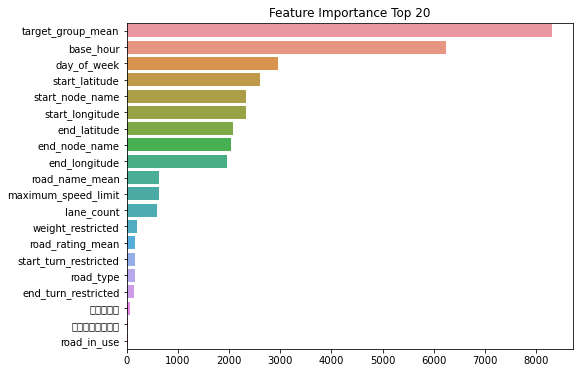

In [170]:
ft_importance_values = lgbm_reg.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = train_X.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [171]:
pred = lgbm_reg.predict(test)

In [175]:
sample['target'] = pred
sample.to_csv(os.path.abspath("../submission")+"/221010_12.csv", index = False)

sample

,id,target
0,TEST_000000,24.994210
1,TEST_000001,43.427829
2,TEST_000002,64.912609
3,TEST_000003,37.970092
4,TEST_000004,41.336523
...,...,...
291236,TEST_291236,48.888430
291237,TEST_291237,52.122613
291238,TEST_291238,20.771899
291239,TEST_291239,21.686382


In [8]:
from pycaret.regression import *

In [9]:
train = train.drop(['start_turn_restricted','end_turn_restricted','id','base_date','road_name','road_rating', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)
.\
test = test.drop(['start_turn_restricted','end_turn_restricted','id','base_date', 'road_name', 'start_node_name','road_rating', 'end_node_name','vehicle_restricted'], axis=1)

In [10]:
reg = setup(data = train, target = 'target',normalize = True)

,Description,Value
0,session_id,7931
1,Target,target
2,Original Data,"(274695, 17)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(192286, 16)"


In [11]:
best_5 = compare_models(sort='MAE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,3.2206,21.1489,4.5987,0.9001,0.1580,0.1127,9.9210
xgboost,Extreme Gradient Boosting,3.2547,20.2873,4.5041,0.9041,0.1567,0.1161,3.1690
catboost,CatBoost Regressor,3.3009,20.6856,4.5480,0.9022,0.1586,0.1181,8.0830
et,Extra Trees Regressor,3.4124,24.1770,4.9169,0.8857,0.1696,0.1189,8.9740
dt,Decision Tree Regressor,3.4336,24.7010,4.9699,0.8833,0.1714,0.1196,0.2170
lightgbm,Light Gradient Boosting Machine,3.7436,25.1464,5.0145,0.8812,0.1752,0.1353,0.5370
knn,K Neighbors Regressor,4.3090,35.2617,5.9380,0.8334,0.2016,0.1532,1.8140
gbr,Gradient Boosting Regressor,5.3228,46.8155,6.8420,0.7788,0.2366,0.1970,5.3040
ada,AdaBoost Regressor,7.5607,87.1815,9.3363,0.5881,0.2987,0.2690,3.2080
huber,Huber Regressor,8.0255,104.9190,10.2429,0.5042,0.3185,0.2845,0.5470


In [13]:
blended = blend_models(estimator_list = best_5, fold = 5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0930,19.1771,4.3792,0.9091,0.1513,0.1092
1,3.1282,19.5281,4.4191,0.9072,0.1525,0.1107
2,3.1209,19.4980,4.4156,0.9080,0.1537,0.1113
3,3.1087,19.2443,4.3868,0.9101,0.1525,0.1103
4,3.1287,19.5384,4.4202,0.9073,0.1520,0.1097
Mean,3.1159,19.3972,4.4042,0.9083,0.1524,0.1103
Std,0.0135,0.1543,0.0175,0.0011,0.0008,0.0007


In [14]:
pred_holdout = predict_model(blended)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,3.0860,18.8641,4.3433,0.9110,0.1499,0.1092


In [15]:
final_model = finalize_model(blended)

In [16]:
predictions = predict_model(final_model, data = test)

In [17]:
predictions.Label

0         25.360280
1         43.339219
2         66.858087
3         38.067023
4         41.563654
            ...    
291236    47.518281
291237    51.087910
291238    21.380501
291239    21.659837
291240    48.078293
Name: Label, Length: 291241, dtype: float64

In [12]:
submission = pd.read_csv('sample_submission.csv')

In [20]:
sample['target'] = predictions.Label
sample

,id,target
0,TEST_000000,25.360280
1,TEST_000001,43.339219
2,TEST_000002,66.858087
3,TEST_000003,38.067023
4,TEST_000004,41.563654
...,...,...
291236,TEST_291236,47.518281
291237,TEST_291237,51.087910
291238,TEST_291238,21.380501
291239,TEST_291239,21.659837


In [21]:
sample.to_csv(os.path.abspath("../submission")+"/pycaret_07~.csv", index = False)

sample

,id,target
0,TEST_000000,25.360280
1,TEST_000001,43.339219
2,TEST_000002,66.858087
3,TEST_000003,38.067023
4,TEST_000004,41.563654
...,...,...
291236,TEST_291236,47.518281
291237,TEST_291237,51.087910
291238,TEST_291238,21.380501
291239,TEST_291239,21.659837


In [44]:
a = pd.read_csv(os.path.abspath("../submission")+"/pycaret_07~.csv")

In [25]:
mae

,id,target
0,TEST_000000,24.599010
1,TEST_000001,43.203895
2,TEST_000002,65.885688
3,TEST_000003,37.701798
4,TEST_000004,41.416041
...,...,...
291236,TEST_291236,48.233336
291237,TEST_291237,51.507068
291238,TEST_291238,22.354911
291239,TEST_291239,22.728329
